# 🏥 Predicting Hospital Readmission Risk
## Student A – Data Engineer / Preprocessing Lead (Binger)


## 1. Setup & Load

In [153]:
# 1.1 Imports & Display Settings
# ------------------------------
import os
import pandas as pd
import numpy as np

# Visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Plot style
plt.style.use("default")
sns.set()

# Pandas display options for easier inspection
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Libraries imported.")


Libraries imported.


In [154]:
!pip install missingno

/etc/zshenv:4: unmatched "

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/bingeryu/PycharmProjects/hospital-readmission-prediction/venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [155]:
from pathlib import Path

# Path to ../results/figures relative to the notebook
FIG_DIR = Path("..") / "results" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)  # create if it doesn't exist


In [156]:
print("Dataset: Diabetes 130-US Hospitals for Years 1999–2008 (UCI Repository)")

Dataset: Diabetes 130-US Hospitals for Years 1999–2008 (UCI Repository)


In [157]:
# 1.2 Define Paths & Load the CSV
# -------------------------------
RAW_DATA_PATH = "../data/raw/diabetic_data.csv"

df = pd.read_csv(RAW_DATA_PATH)
print("Data loaded.")


Data loaded.


## 2. Review the Dataset

In [158]:
# 2.1 Quick Peek
# --------------
# First 5 rows
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [159]:
df.shape
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [160]:
# 2.2 Shape and Column Listprint("Number of rows:", df.shape[0])
# --------------------------------------------------------------
print("Number of columns:", df.shape[1])
print("\nColumns:")
print(df.columns.tolist())


Number of columns: 50

Columns:
['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [161]:
# 2.3 Data Types + Non-null Counts
# --------------------------------
# Quick infor summary: non-null counts and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [162]:
# 2.4 Basic Numeric Summary
# --------------------------
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [163]:
# Basic stats including categorical columns
df.describe(include="all").T.head(15) # first 15 rows of summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,NaN,NaN,NaN,165201645.622978,102640295.983457,12522.0,84961194.0,152388987.0,230270887.5,443867222.0
patient_nbr,101766.0,NaN,NaN,NaN,54330400.694947,38696359.346534,135.0,23413221.0,45505143.0,87545949.75,189502619.0
race,101766,6,Caucasian,76099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,101766,3,Female,54708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,101766,10,[70-80),26068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,101766,10,?,98569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_id,101766.0,NaN,NaN,NaN,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,NaN,NaN,NaN,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,NaN,NaN,NaN,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,NaN,NaN,NaN,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0


In [164]:
# 2.5 How Many Unique Values per Column?
# --------------------------------------
# Number of unique values per column
nunique = df.nunique().sort_values(ascending=False)
nunique.head(20)


encounter_id                101766
patient_nbr                  71518
diag_3                         790
diag_2                         749
diag_1                         717
num_lab_procedures             118
num_medications                 75
medical_specialty               73
number_outpatient               39
number_emergency                33
discharge_disposition_id        26
number_inpatient                21
payer_code                      18
admission_source_id             17
number_diagnoses                16
time_in_hospital                14
age                             10
weight                          10
admission_type_id                8
num_procedures                   7
dtype: int64

In [165]:
# 2.6 Check the Target Variable (readmitted)
# ------------------------------------------
df["readmitted"].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [166]:
# And with proportions
df["readmitted"].value_counts(normalize=True)


readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64

In [167]:
# 2.7 Missing Values Overview
# ---------------------------
# How many "?" entries overall?
(df == "?").sum().sort_values(ascending=False).head(20)


weight               98569
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
encounter_id             0
tolazamide               0
glyburide                0
tolbutamide              0
pioglitazone             0
rosiglitazone            0
acarbose                 0
miglitol                 0
troglitazone             0
citoglipton              0
examide                  0
acetohexamide            0
insulin                  0
dtype: int64

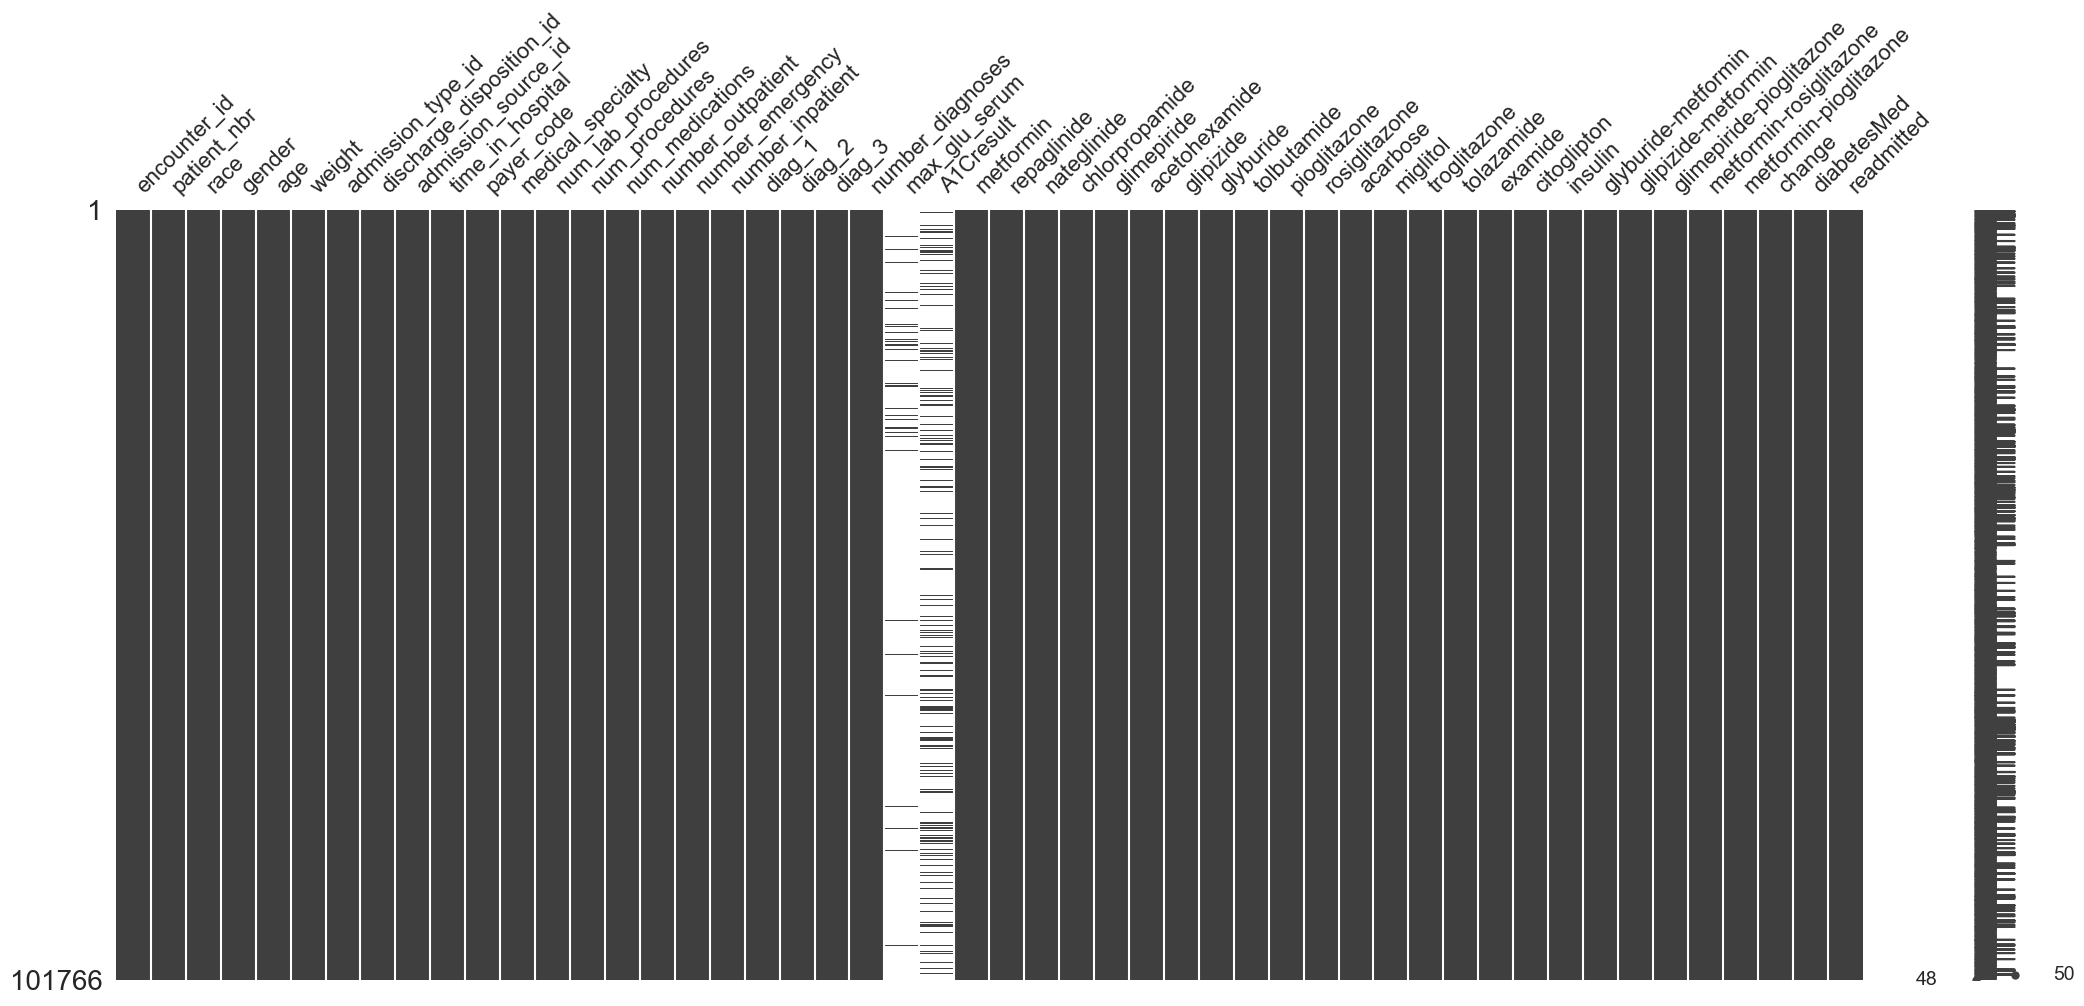

In [168]:
msno.matrix(df)
plt.show()

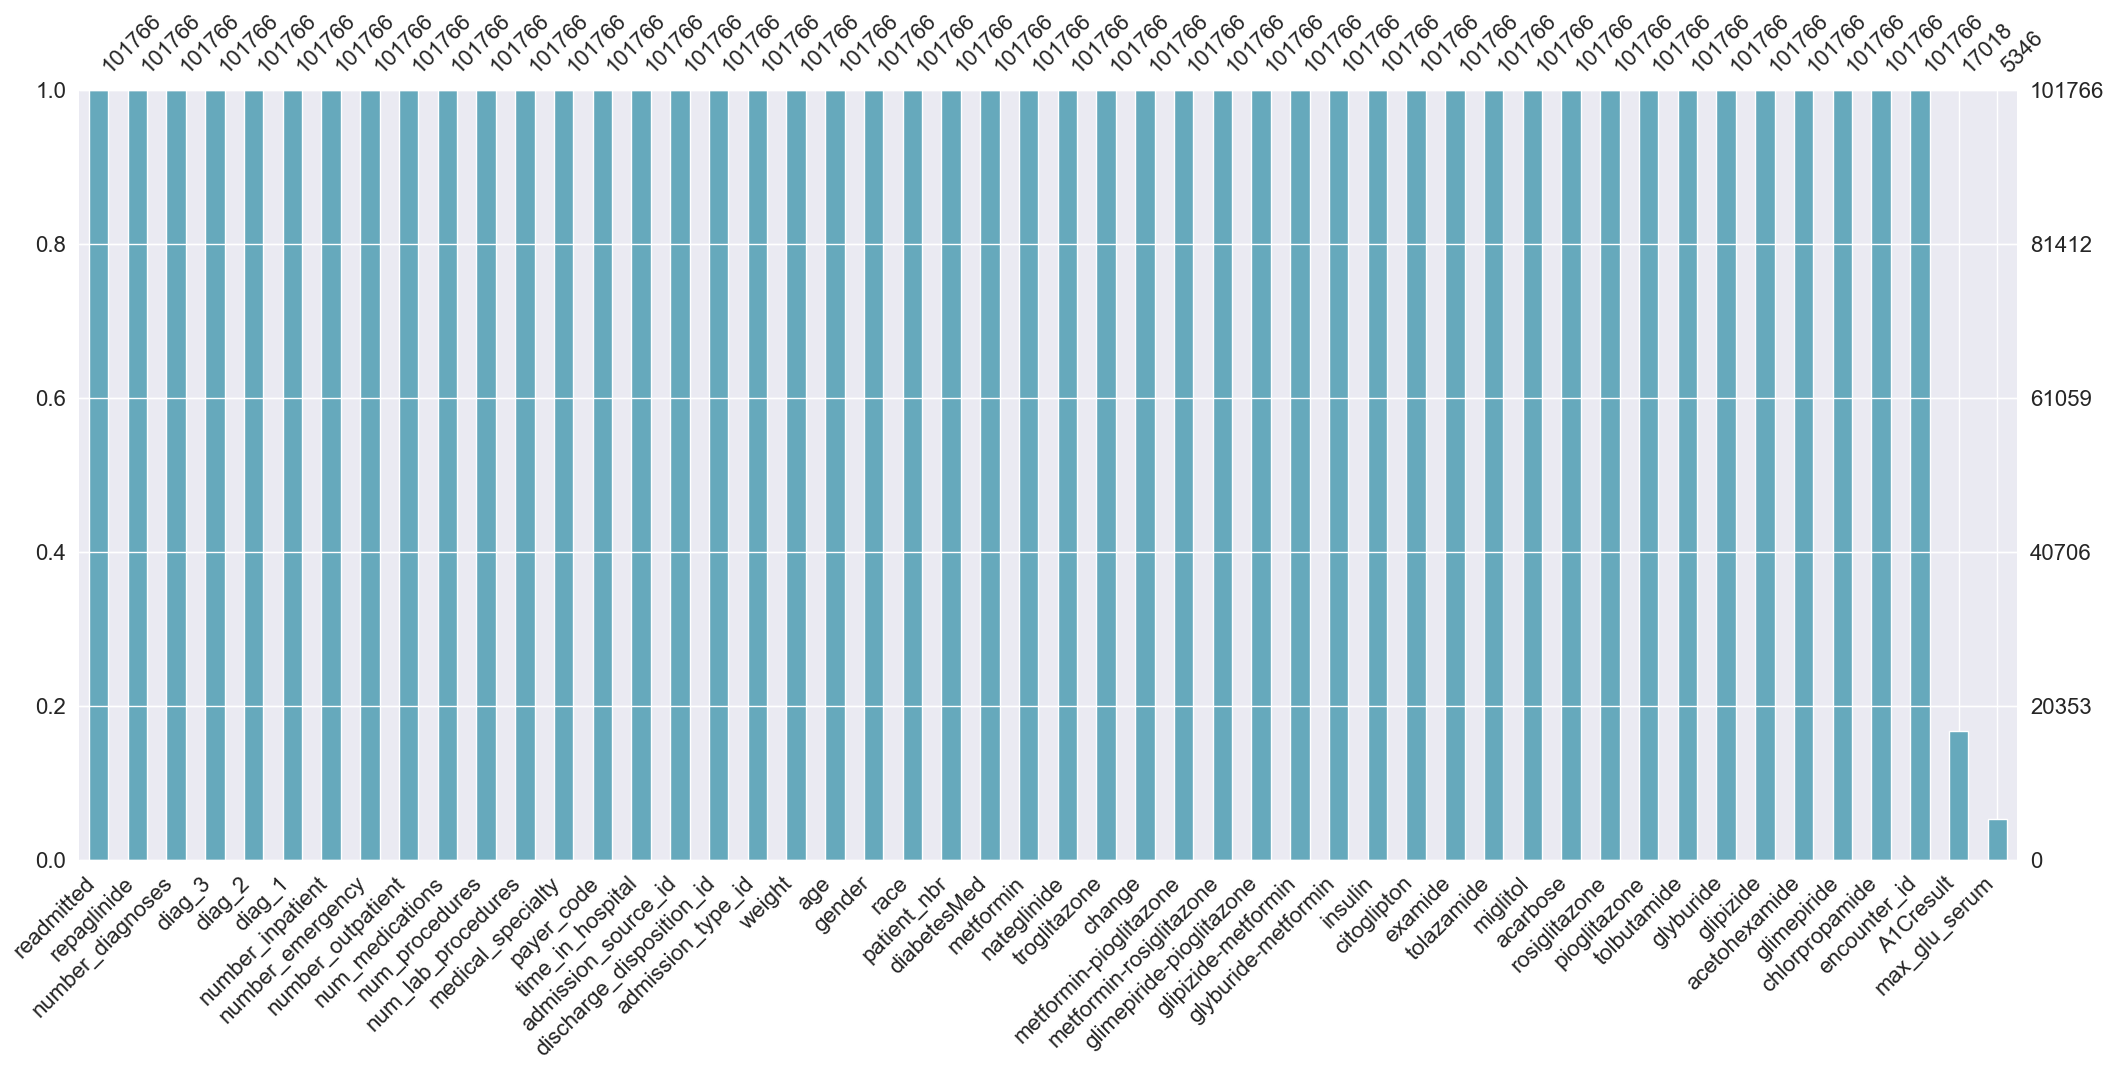

In [169]:
msno.bar(df,sort='descending',color='#66a9bc')
plt.show()

**Observations:**

- The dataset contains 101,766 encounters and 50 attributes.
- The target variable `readmitted` is imbalanced, with the majority of encounters not readmitted within 30 days.
- Several columns (`weight`, `max_glu_serum`, `A1Cresult`, `medical_specialty`, `payer_code`) have a high fraction of missing values and will be removed in preprocessing.


In [170]:
# gender was coded differently so we use a custom count for this one            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())  

gender 3


In [171]:
# Drop invalid gender rows
df = df[df['gender'] != 'Unknown/Invalid']
print("Remaining rows:", len(df))


Remaining rows: 101763


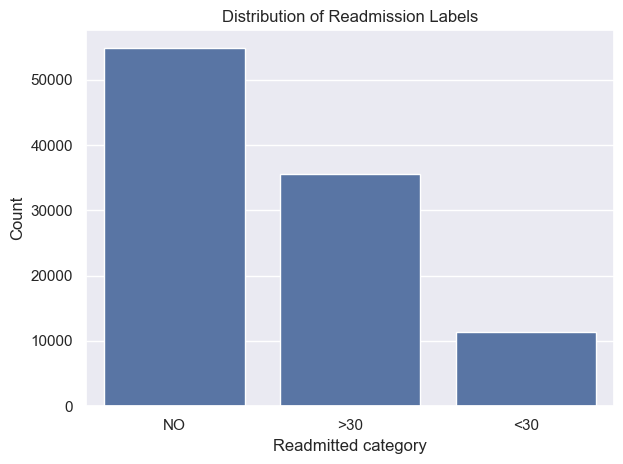

In [172]:
# Bar plot of readmitted distribution
sns.countplot(x="readmitted", data=df)
plt.title("Distribution of Readmission Labels")
plt.xlabel("Readmitted category")
plt.ylabel("Count")
plt.tight_layout()


## 3. Data Cleaning

In [173]:
missing_ratio = df.isna().sum() / len(df)
print("Top columns with missing values:")
print(missing_ratio.sort_values(ascending=False).head(10))


Top columns with missing values:
max_glu_serum    0.947466
A1Cresult        0.832768
encounter_id     0.000000
nateglinide      0.000000
glimepiride      0.000000
acetohexamide    0.000000
glipizide        0.000000
glyburide        0.000000
tolbutamide      0.000000
pioglitazone     0.000000
dtype: float64


In [174]:
# Replace '?' with NaN for consistency
df = df.replace('?', np.nan)

# Drop columns with too many missing values or IDs
cols_to_drop = ['weight', 'payer_code', 'medical_specialty',
                'encounter_id', 'patient_nbr']
df.drop(columns=cols_to_drop, inplace=True)

# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Re-check missing data
df.isnull().sum().sort_values(ascending=False).head(10)


Duplicates: 0


max_glu_serum    96417
A1Cresult        84745
race              2271
diag_3            1423
diag_2             358
diag_1              21
tolbutamide          0
pioglitazone         0
rosiglitazone        0
acarbose             0
dtype: int64

Columns with excessive missing values (weight, payer_code, medical_specialty) or identifiers (encounter_id, patient_nbr) were removed to improve model stability.

In [175]:
# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Re-check missing data
df.isnull().sum().sort_values(ascending=False).head(10)


Duplicates: 0


max_glu_serum    96417
A1Cresult        84745
race              2271
diag_3            1423
diag_2             358
diag_1              21
tolbutamide          0
pioglitazone         0
rosiglitazone        0
acarbose             0
dtype: int64

In [176]:
# Drop heavy missing-value columns
cols_to_drop = ['max_glu_serum', 'A1Cresult']
df.drop(columns=cols_to_drop, inplace=True)
print(f"Dropped columns: {cols_to_drop}")


Dropped columns: ['max_glu_serum', 'A1Cresult']


In [177]:
# Re-check missing data
df.isnull().sum().sort_values(ascending=False).head(10)

race             2271
diag_3           1423
diag_2            358
diag_1             21
tolazamide          0
tolbutamide         0
pioglitazone        0
rosiglitazone       0
acarbose            0
miglitol            0
dtype: int64

In [178]:
# Handle small missing subsets
# Fill missing 'race' with mode (most common value)
df['race'] = df['race'].fillna(df['race'].mode()[0])

# Fill diagnosis codes with a placeholder
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].fillna('Unknown')


In [179]:
# Re-check missing data
df.isnull().sum().sort_values(ascending=False).head(10)

race             0
examide          0
glyburide        0
tolbutamide      0
pioglitazone     0
rosiglitazone    0
acarbose         0
miglitol         0
troglitazone     0
tolazamide       0
dtype: int64

Features `max_glu_serum` and `A1Cresult` were dropped due to excessive missingness (>80%).
Minor missing values in `race` were imputed with the most frequent category, while missing diagnosis codes were replaced with “Unknown” to retain encounters.

## 4. Feature Encoding & Target Transformation

In this section, we perform the final preprocessing and feature transformation steps
to prepare the dataset for modeling. This includes encoding the target variable,
transforming categorical features into numeric form, and creating new derived features.


In [180]:
# 4.1 Encode Target Variable (readmitted_binary)
# ------------------------------------------------
# Convert readmission categories ("NO", ">30", "<30") into a binary target variable.

df["readmitted"].value_counts()

readmit_map = {'<30': 1, '>30': 0, 'NO': 0}
df['readmitted_binary'] = df['readmitted'].map(readmit_map).astype('int8')

# Check distribution
print(df['readmitted_binary'].value_counts())
print(df['readmitted_binary'].value_counts(normalize=True))

# Note: The target is highly imbalanced (~89% no readmission vs. 11% readmitted within 30 days)


readmitted_binary
0    90406
1    11357
Name: count, dtype: int64
readmitted_binary
0    0.888398
1    0.111602
Name: proportion, dtype: float64


The target variable `readmitted_binary` represents whether a patient was readmitted
within 30 days (`1`) or not (`0`). The dataset exhibits a significant class imbalance,
which will be addressed in the modeling phase.


In [181]:
# 4.2 Convert Age Ranges to Midpoints (age_mid)
# ----------------------------------------------
# Convert categorical age intervals (e.g., "[40-50)") into numeric midpoints (e.g., 45).

age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age_mid'] = df['age'].map(age_map)


The new numeric feature `age_mid` preserves ordering information from the
categorical `age` variable while simplifying numerical analysis and visualization.


In [182]:
# 4.3 Create Service Utilization Feature
# ---------------------------------------
# Combine outpatient, emergency, and inpatient visits into a single aggregated feature.

df['service_utilization'] = (
    df['number_outpatient'] +
    df['number_emergency'] +
    df['number_inpatient']
)


We created age_mid (age interval midpoints) and service_utilization (total prior visits) as simple feature transformations for modeling.

In [183]:
# 4.4 Save Processed Dataset
# ---------------------------
# Save the cleaned and feature-engineered dataset for use in modeling.

output_path = "../data/processed/diabetic_data_clean.csv"
df.to_csv(output_path, index=False)
print(f"Saved processed dataset to {output_path}")


Saved processed dataset to ../data/processed/diabetic_data_clean.csv


The processed dataset is saved for subsequent modeling and explainability analysis.


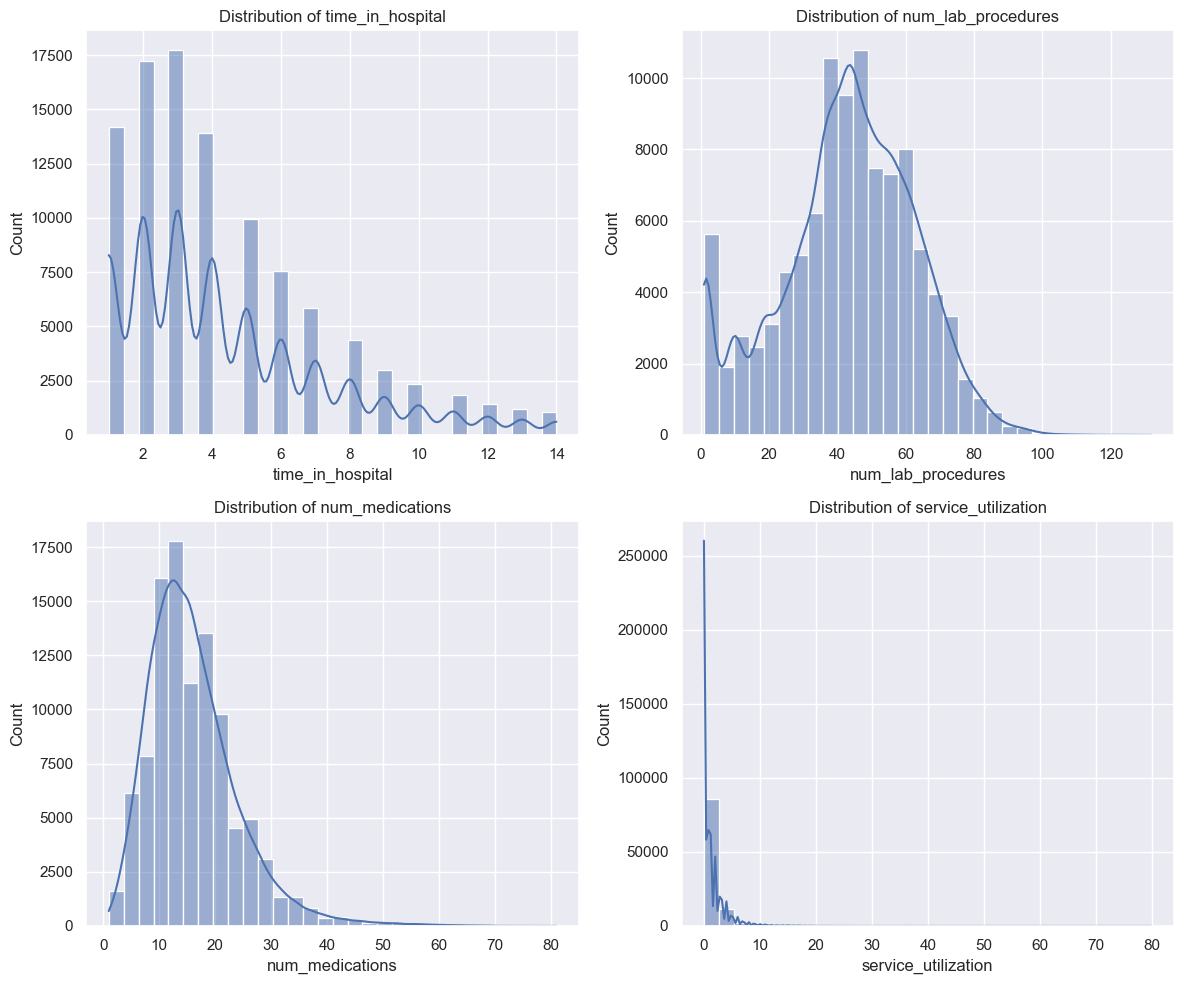

In [184]:
# 4.5 Basic Visualizations for Dataset Description
import matplotlib.pyplot as plt
import seaborn as sns

numeric_vars = ['time_in_hospital',
                'num_lab_procedures',
                'num_medications',
                'service_utilization']

plt.figure(figsize=(12, 10))

for i, col in enumerate(numeric_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.savefig(FIG_DIR / "fig2_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


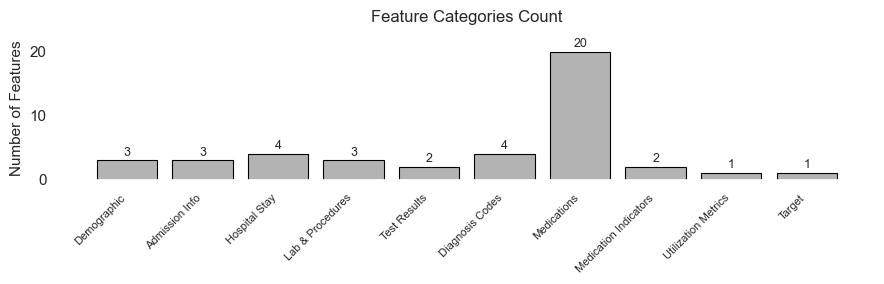

In [185]:
# 4.6 Feature Categories Count
fig, ax = plt.subplots(figsize=(9, 3))  # you can also reduce height a bit

bars = ax.bar(labels, counts, color="0.7", edgecolor="black", linewidth=0.8)

ax.set_title("Feature Categories Count", fontsize=12, pad=10)
ax.set_ylabel("Number of Features", fontsize=11)

ax.set_facecolor("white")
fig.patch.set_facecolor("white")
ax.grid(False)

# smaller x-tick labels to save space
plt.xticks(rotation=45, ha="right", fontsize=8)   # <= key change
# or: ax.tick_params(axis="x", labelsize=8)

ax.set_ylim(0, max(counts) + 2.5)

for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.3, f"{h}",
            ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("../results/figures/feature_category_counts_clean.png",
            dpi=300, bbox_inches="tight")
plt.show()


## 5. Exploratory Data Analysis (EDA)

In this section, we visualize distributions, relationships, and trends
in the cleaned dataset to gain insights that may inform feature importance
and model design.


In [186]:
# 5.1 Dataset Overview
# ---------------------
print(df.shape)
df.info()
df.describe(include='all')


(101763, 46)
<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101763 non-null  object
 1   gender                    101763 non-null  object
 2   age                       101763 non-null  object
 3   admission_type_id         101763 non-null  int64 
 4   discharge_disposition_id  101763 non-null  int64 
 5   admission_source_id       101763 non-null  int64 
 6   time_in_hospital          101763 non-null  int64 
 7   num_lab_procedures        101763 non-null  int64 
 8   num_procedures            101763 non-null  int64 
 9   num_medications           101763 non-null  int64 
 10  number_outpatient         101763 non-null  int64 
 11  number_emergency          101763 non-null  int64 
 12  number_inpatient          101763 non-null  int64 
 13  diag_1                    101763 non-null  object
 

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary,age_mid,service_utilization
count,101763,101763,101763,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763,101763,101763,101763.000000,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763.000000,101763.000000,101763.000000
unique,5,2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,717,749,790,NaN,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3,NaN,NaN,NaN
top,Caucasian,Female,[70-80),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,NaN,NaN,NaN
freq,78370,54708,26066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,81776,100224,101060,101677,96572,101762,89078,91113,101740,94436,95399,101455,101725,101760,101724,101763,101763,47380,101057,101750,101762,101761,101762,54754,78361,54861,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.024017,3.715515,5.754459,4.396018,43.095909,1.339691,16.021835,0.369368,0.197842,0.635585,NaN,NaN,NaN,7.422649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111602,65.966854,1.202795
std,NaN,NaN,NaN,1.445414,5.279919,4.064110,2.985092,19.674220,1.705792,8.127589,1.267282,0.930485,1.262877,NaN,NaN,NaN,1.933578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.314878,15.941022,2.291805
min,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.000000,0.000000
25%,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,55.000000,0.000000
50%,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,65.000000,0.000000
75%,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,75.000000,2.000000


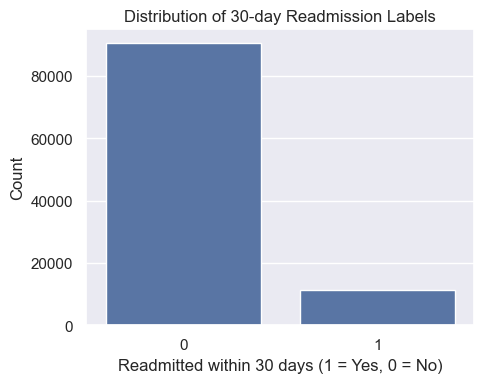

In [187]:
# 5.2 Class Imbalance Visualization
# ---------------------------------
plt.figure(figsize=(5, 4))
sns.countplot(x='readmitted_binary', data=df)
plt.title("Distribution of 30-day Readmission Labels")
plt.xlabel("Readmitted within 30 days (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig_readmission_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


The dataset is imbalanced, with only ~11% of patients readmitted within 30 days. This imbalance highlights the need for resampling or class-weighting techniques in later modeling stages.

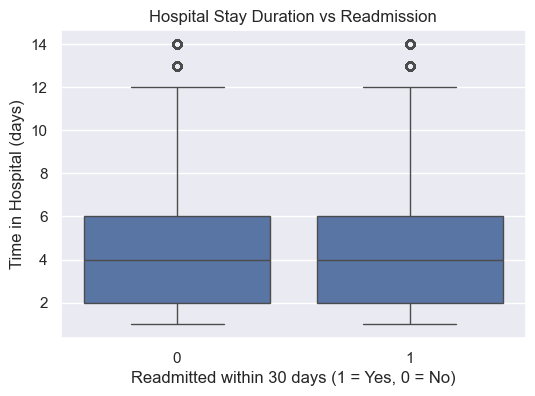

In [188]:
# 5.3 Continuous Feature Distributions
# ------------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='readmitted_binary', y='time_in_hospital', data=df)
plt.title("Hospital Stay Duration vs Readmission")
plt.xlabel("Readmitted within 30 days (1 = Yes, 0 = No)")
plt.ylabel("Time in Hospital (days)")
plt.show()


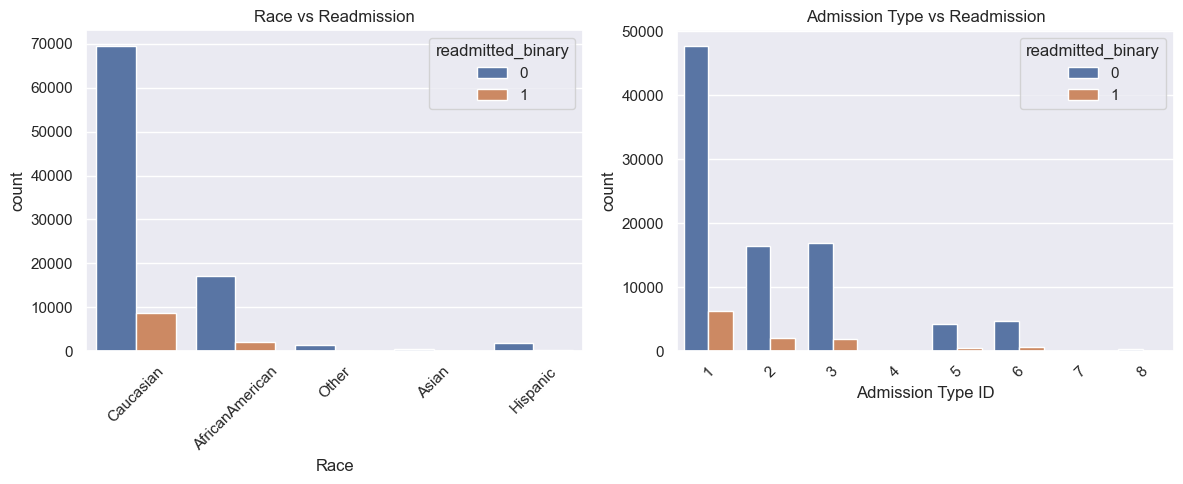

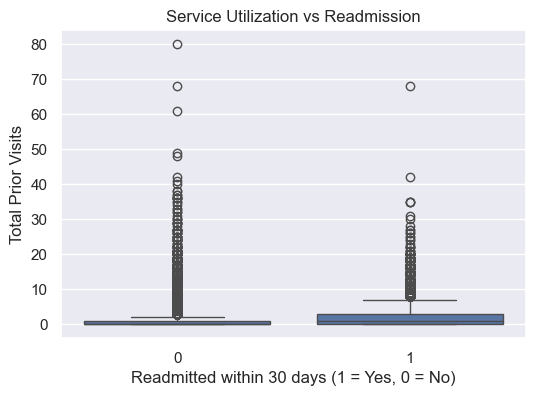

In [189]:
# 5.4 Feature Relationships (categorical features)
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='race', hue='readmitted_binary', data=df, ax=axes[0])
axes[0].set_title("Race vs Readmission")
axes[0].set_xlabel("Race")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x='admission_type_id', hue='readmitted_binary', data=df, ax=axes[1])
axes[1].set_title("Admission Type vs Readmission")
axes[1].set_xlabel("Admission Type ID")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='readmitted_binary', y='service_utilization', data=df)
plt.title("Service Utilization vs Readmission")
plt.xlabel("Readmitted within 30 days (1 = Yes, 0 = No)")
plt.ylabel("Total Prior Visits")
plt.show()


Features `A1Cresult` and `max_glu_serum` were dropped earlier due to excessive missingness (>80%).
We instead examine relationships between readmission and remaining features such as race, admission type, and service utilization.

In [190]:
print(df.columns.tolist())
print(len(df.columns))


['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'readmitted_binary', 'age_mid', 'service_utilization']
46


### 5.5 Observations

- The dataset is highly imbalanced, with ~11% of patients readmitted within 30 days.
- Longer hospital stays and higher A1C values tend to correlate with readmission risk.
- Patients with higher `service_utilization` show a greater likelihood of readmission.
- These findings will guide feature importance analysis and model design in later stages.
